In [1]:
import polars as pl
import requests
# to enrich the examples in this quickstart with dates
from datetime import datetime, timedelta 
# to generate data for the examples
import numpy as np 
from os import listdir
import matplotlib.pyplot as plt
from functions import get_price, get_tag

In [89]:
fname=listdir("data\\")[0]
df=pl.read_csv(f"data\\{fname}")
CloseV=df.select("Close")
df.select("Date")

Date
str
"""2013-01-02"""
"""2013-01-03"""
"""2013-01-04"""
"""2013-01-07"""
"""2013-01-08"""
"""2013-01-09"""
"""2013-01-10"""
"""2013-01-11"""
"""2013-01-14"""


In [51]:
#Get company tags through Yahoo Financial 
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
stock_cat={}
cNames=[]
cInds=[]
cSec=[]
for fname in listdir("data\\"):
    stock_tag=fname.split("(")[0]
    company_name=fname.split("(")[1].split(")")[0]
    res=requests.get(f"https://query1.finance.yahoo.com/v10/finance/quoteSummary/{stock_tag}?formatted=true&crumb=ATn%2FOzVhnFV&lang=en-CA&region=CA&modules=summaryProfile%2CfinancialData%2CrecommendationTrend%2CupgradeDowngradeHistory%2Cearnings%2CdefaultKeyStatistics%2CesgScores%2Cdetails&corsDomain=ca.finance.yahoo.com",headers=headers)
    stockSummary=res.json()['quoteSummary']['result'][0]['summaryProfile']
    industry=stockSummary["industry"]
    sector=stockSummary["sector"]
    cNames.append(company_name)
    cInds.append(industry)
    cSec.append(sector)
stock_cat["Company Name"]=cNames
stock_cat["Industries"]=cInds
stock_cat["Sector"]=cSec

In [54]:
#Save file as parquet
pl.DataFrame(stock_cat).write_parquet("StockCat.parquet")

In [64]:
df=pl.read_parquet("StockCat.parquet")

In [66]:
Tech_Comp=df.filter(pl.col("Sector")=="Technology").select(pl.col("Company Name"))

2518
2518
2518
2518
2518
2518
2518
1580


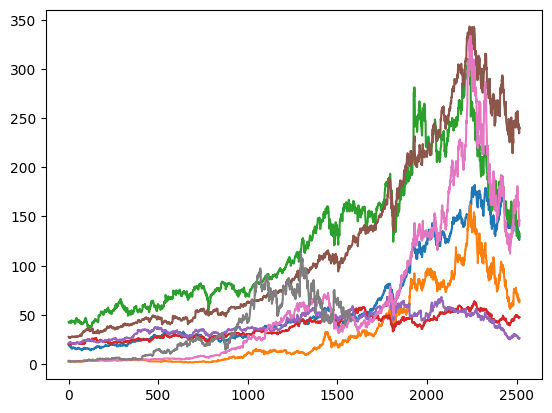

In [87]:

for i in range(Tech_Comp.shape[0]):
    for j in listdir("data\\"):
        if Tech_Comp[i].item() in j:
            df=pl.read_csv(f"data\\{j}")
            CloseV=df.select("Close")
            plt.plot(CloseV)
            print(CloseV.shape[0])

In [85]:
Tech_Comp.shape

(8, 1)

In [81]:
Tech_Comp[1].item()

'AMD'

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res=requests.get("https://query2.finance.yahoo.com/v8/finance/chart/SOFI?formatted=true&crumb=ATn%2FOzVhnFV&lang=en-CA&region=CA&events=capitalGain%7Cdiv%7Csplit&includeAdjustedClose=true&interval=1d&range=10y&useYfid=true&corsDomain=ca.finance.yahoo.com",headers=headers)

In [16]:
res.json()["chart"]['result'][0]['meta'].keys()

dict_keys(['currency', 'symbol', 'exchangeName', 'instrumentType', 'firstTradeDate', 'regularMarketTime', 'gmtoffset', 'timezone', 'exchangeTimezoneName', 'regularMarketPrice', 'chartPreviousClose', 'priceHint', 'currentTradingPeriod', 'dataGranularity', 'range', 'validRanges'])

In [18]:
res.json()["chart"]['result'][0]['meta']['dataGranularity']

'1d'

In [38]:
res.json()["chart"]['result'][0]['timestamp']

[1609770600,
 1609857000,
 1609943400,
 1610029800,
 1610116200,
 1610375400,
 1610461800,
 1610548200,
 1610634600,
 1610721000,
 1611066600,
 1611153000,
 1611239400,
 1611325800,
 1611585000,
 1611671400,
 1611757800,
 1611844200,
 1611930600,
 1612189800,
 1612276200,
 1612362600,
 1612449000,
 1612535400,
 1612794600,
 1612881000,
 1612967400,
 1613053800,
 1613140200,
 1613485800,
 1613572200,
 1613658600,
 1613745000,
 1614004200,
 1614090600,
 1614177000,
 1614263400,
 1614349800,
 1614609000,
 1614695400,
 1614781800,
 1614868200,
 1614954600,
 1615213800,
 1615300200,
 1615386600,
 1615473000,
 1615559400,
 1615815000,
 1615901400,
 1615987800,
 1616074200,
 1616160600,
 1616419800,
 1616506200,
 1616592600,
 1616679000,
 1616765400,
 1617024600,
 1617111000,
 1617197400,
 1617283800,
 1617629400,
 1617715800,
 1617802200,
 1617888600,
 1617975000,
 1618234200,
 1618320600,
 1618407000,
 1618493400,
 1618579800,
 1618839000,
 1618925400,
 1619011800,
 1619098200,
 1619184600,

In [2]:
CATech=["CSU","SHOP","NVEI","CDAY","MAGT","DCBO","DND","T","OTEX","LSPD","ENGH","TOI","WE","TSAT","PTK","DGHI","CLS"]

In [34]:
get_tag(CATech[0]+".TO")

('Software—Application', 'Technology')

In [5]:
for stock_tag in df["RY"].to_numpy():
    StockProfile={}
    try:
        time,price=get_price(stock_tag+".TO",13)
        ind,sec=get_tag(stock_tag+".TO")
        StockProfile["Time"]=time
        StockProfile["Price"]=price
        pl.DataFrame(StockProfile).write_parquet(f"CAData\\{stock_tag}_{ind}_{sec}.parquet")
    except:
        print("No Data Avaiable")
        pass

No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable
No Data Avaiable


In [11]:
for stock_tag in pl.read_csv("CN.csv")['600340'].to_numpy():
    StockProfile={}
    try:
        time,price=get_price(str(stock_tag)+".SS",13)
        ind,sec=get_tag(str(stock_tag)+".SS")
        StockProfile["Time"]=time
        StockProfile["Price"]=price
        pl.DataFrame(StockProfile).write_parquet(f"CNData\\{stock_tag}_{ind}_{sec}.parquet")
    except:
        pass

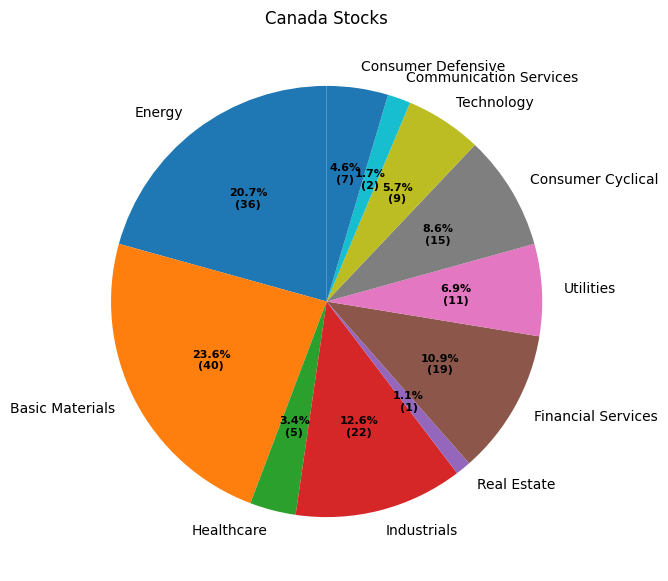

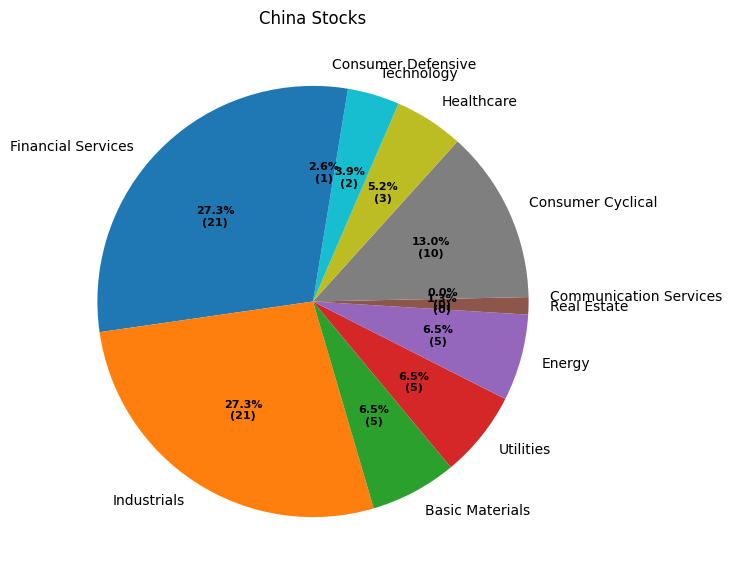

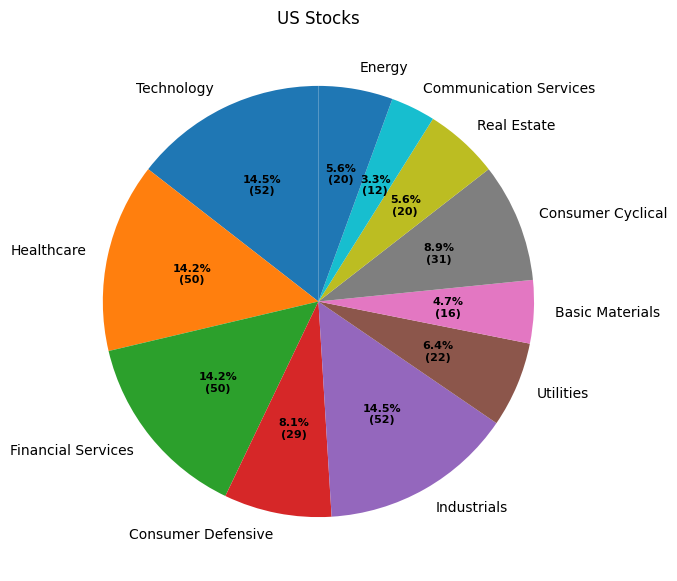

In [32]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
directions=["CAData\\","CNData\\","USData\\"]
titles=["Canada Stocks","China Stocks","US Stocks"]
categoryCA={}
categoryCN={}
categoryUS={}
categories=[categoryCA,categoryCN,categoryUS]
for i in range(len(directions)):
    for j in listdir(directions[i]):
        industry=j.split("_")[2].split(".")[0]
        try:
            categories[i][industry]+=1
        except:
            categories[i][industry]=0
    inds=list(categories[i].keys())
    vals=list(categories[i].values())
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(vals,
                                  autopct = lambda pct: func(pct, vals),
                                  
                                  labels = inds,
                                  startangle = 90,
    )
    
    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title("Customizing pie chart")
    plt.title(titles[i])
        



In [25]:
list(categories[i].keys())

['Technology',
 'Healthcare',
 'Financial Services',
 'Consumer Defensive',
 'Industrials',
 'Utilities',
 'Basic Materials',
 'Consumer Cyclical',
 'Real Estate',
 'Communication Services',
 'Energy']